In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 21 - Medical Cost\insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

# Sex, smoker and region needs to be numerized.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


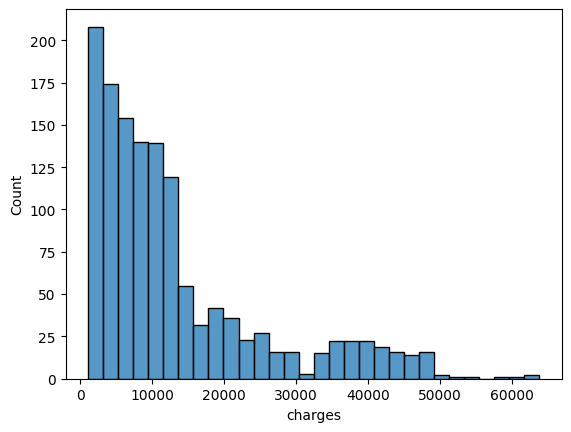

In [7]:
sns.histplot(df.charges)
plt.show()

# Right skew on the charges, need log transformation 

In [8]:
column_objects = ['sex', 'smoker', 'region']

for col in column_objects:
    print(df[col].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [9]:
transformed_col = {
    'sex': {
        'male': 1,
        'female': 0
    },
    'smoker':{
        'yes': 1,
        'no': 0
    },
    'region':{
        'southeast': 0,
        'southwest': 1,
        'northwest': 2,
        'northeast': 3
    }
}


for col, mapping in transformed_col.items():
    df[col] = df[col].map(mapping)

In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,1,16884.92400
1,18,1,33.770,1,0,0,1725.55230
2,28,1,33.000,3,0,0,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520


<Axes: >

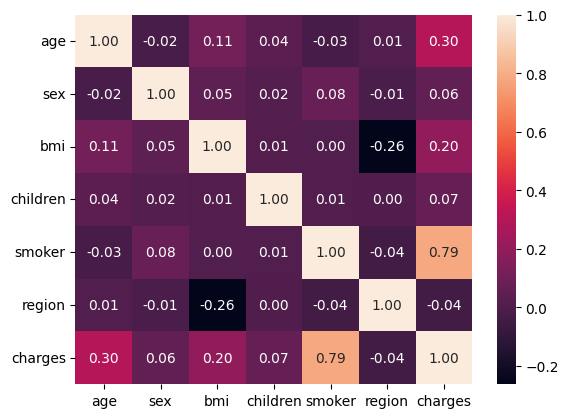

In [11]:
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

# V strong correlation seen in charge and smokers and moderate in age, correlation seems insignificant in BMI and region, might remove region 

In [12]:
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.006308,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.012816,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,-0.262754,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.001205,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.038873,0.787251
region,0.006308,-0.012816,-0.262754,0.001205,-0.038873,1.000000,-0.039473
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.039473,1.000000


In [13]:
X = df.drop(columns = ['region', 'charges'])
y = np.log1p(df.charges)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= df.smoker)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
models = {
    'LinearRegression':{
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(random_state= 2),
        'params':{
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state= 2),
        'params':{
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Random Forest':{
        'model': RandomForestRegressor(random_state= 2),
        'params':{
            'max_depth': [None, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4],
            'n_estimators': [50, 100, 200],
            'max_features':[None, 'sqrt', 0.8]
        }
    },
    'XGBRegressor':{
        'model': XGBRegressor(random_state = 2),
        'params':{
            'max_depth': [3, 5, 6, 8],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
}

In [17]:
results = {}
all_models = {}

for name, config in models.items():
    grid_search =  GridSearchCV(
        config['model'],
        config['params'],
        cv = 5,
        scoring = 'neg_mean_absolute_error',
        n_jobs = -1,
        verbose = 1

    )

    grid_search.fit(X_train_scaled, y_train)
    all_models[name] = grid_search.best_estimator_

    train_pred = grid_search.best_estimator_.predict(X_train_scaled)
    test_pred = grid_search.best_estimator_.predict(X_test_scaled)


    results[name] = {
        'best_model' : grid_search.best_estimator_,
        'best_params' : grid_search.best_params_,
        'Train R2' : r2_score(y_train, train_pred),
        'Test R2': r2_score(y_test, test_pred),
        'Train MAE' : mean_absolute_error(y_train, train_pred),
        'Test MAE': mean_absolute_error(y_test, test_pred),
        'Train RMSE' : np.sqrt(mean_squared_error(y_train, train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred))
    }

best_model_name = max(results.keys(), key = lambda x: results[x]['Test R2'])
model = results[best_model_name]['best_model']

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
summary_data = []

for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Test R2': result['Test R2'],    
        'Test RMSE': result['Test RMSE'],
        'Overfit Gap': result['Train R2'] - result['Test R2'],
})


summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test R2', ascending= False)
summary_df = summary_df.round(4)
print(summary_df.to_string(index = False))


           Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
   Random Forest     0.1727    0.1955      0.3265     0.3717    0.8713   0.8472
    XGBRegressor     0.1871    0.2022      0.3464     0.3741    0.8552   0.8452
LinearRegression     0.2868    0.2699      0.4488     0.4392    0.7569   0.7866
           Ridge     0.2868    0.2699      0.4488     0.4392    0.7569   0.7866
           Lasso     0.3254    0.3275      0.4860     0.4978    0.7149   0.7259


In [21]:
# Double-check with cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                           cv=5, scoring='r2')
print(f"Cross-validation R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation R²: 0.8234 (+/- 0.0862)
